### Explore changes in beliefs in certain conditions, motivate neural analyses
https://www.notion.so/walkerlab/Revisiting-feedback-interactions-1ac2dc9f99928094b7c3e9cab6732cad 


In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns

### Get sessions, beliefs

In [4]:
num_bins = 10

def compute_kl(p_dist, q_dist):
    """
    Assumes two categorical distributions
    p_dist: n_samples x n_categories
    q_dist: n_samples x n_categories
    Returns: 
        kl: n_samples
    """
    return np.sum(p_dist * np.log(p_dist / q_dist), axis=1)

def make_bernoulli_dist(probs):
    dist = np.empty((len(probs), 2))
    dist[:, 0] = probs
    dist[:, 1] = 1 - probs
    return dist

def get_sess_beh(row, beh_path):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    beh["PrevResponse"] = beh.Response.shift()
    beh = beh[~beh.PrevResponse.isna()]
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session)

    beh[[f"{feat}LogProb" for feat in FEATURES]] = np.log(beh[[f"{feat}Prob" for feat in FEATURES]])

    beh[[f"Next{feat}Prob" for feat in FEATURES]] = beh[[f"{feat}Prob" for feat in FEATURES]].shift(-1)
    beh[[f"Next{feat}LogProb" for feat in FEATURES]] = beh[[f"{feat}LogProb" for feat in FEATURES]].shift(-1)

    beh["BeliefStateValue"] = beh.BeliefStateValue.shift(-1)
    beh = beh[~beh.BeliefStateValue.isna()]

    for feat in FEATURES: 
        beh[f"{feat}ProbDelta"] = beh[f"Next{feat}Prob"] - beh[f"{feat}Prob"]
        beh[f"{feat}LogProbDelta"] = beh[f"Next{feat}LogProb"] - beh[f"{feat}LogProb"]

        beh[f"{feat}KL"] = compute_kl(
            make_bernoulli_dist(beh[f"{feat}Prob"]),
            make_bernoulli_dist(beh[f"Next{feat}Prob"])
        )
    med = beh.BeliefStateValue.median()
    beh["BeliefStateValueBin"] = beh.apply(lambda x: 0 if x.BeliefStateValue < med else 1, axis=1)
    beh["PreferredBelief"] = beh[[f"{feat}Prob" for feat in FEATURES]].idxmax(axis=1).apply(lambda x: x[:-4])
    beh["BeliefLabel"] = beh.apply(lambda x: f"High Value Pref {x.PreferredBelief}" if x.BeliefStateValueBin == 1 else "Low Value", axis=1)
    beh["session"] = session
    return beh

In [5]:
# Monkey S
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH
all_beh = pd.concat(sessions.apply(lambda x: get_sess_beh(x, beh_path), axis=1).values)
all_beh["CombinedIdx"] = np.arange(len(all_beh))

KeyError: 'sub'

### Prediction 1: When value is low, expected reward low, unrewarded trials aren’t changing beliefs much, rewarded trials are changing beliefs more. 

Text(0, 0.5, '$|\\Delta b(z)|$')

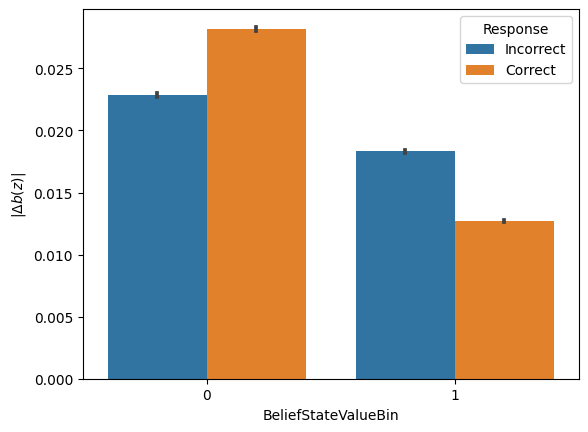

In [4]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin"], value_vars=[f"{feat}ProbDelta" for feat in FEATURES])
melted["mag"] = melted["value"].abs()

fig, ax = plt.subplots()
sns.barplot(melted, x="BeliefStateValueBin", hue="Response", y="mag", ax=ax)
ax.set_ylabel(r"$|\Delta b(z)|$")

Text(0, 0.5, '$|\\Delta log(b(z))|$')

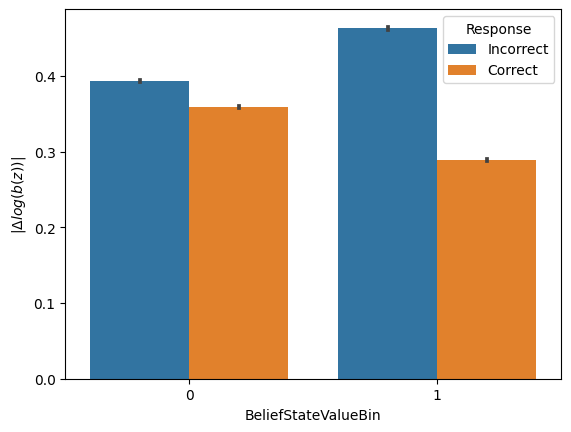

In [6]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin"], value_vars=[f"{feat}LogProbDelta" for feat in FEATURES])
melted["mag"] = melted["value"].abs()

fig, ax = plt.subplots()
sns.barplot(melted, x="BeliefStateValueBin", hue="Response", y="mag", ax=ax)
ax.set_ylabel(r"$|\Delta log(b(z))|$")

Text(0, 0.5, '$KL$')

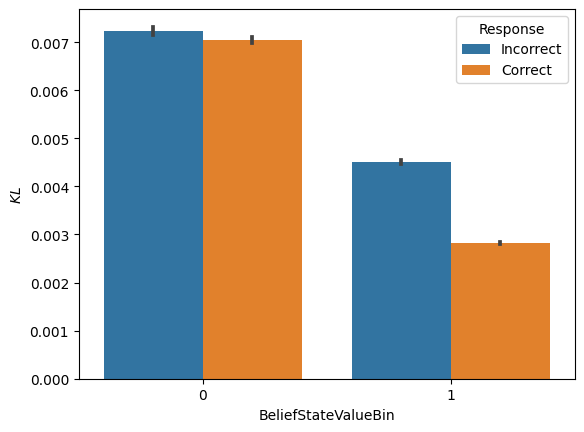

In [9]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin"], value_vars=[f"{feat}KL" for feat in FEATURES])

fig, ax = plt.subplots()
sns.barplot(melted, x="BeliefStateValueBin", hue="Response", y="value", ax=ax)
ax.set_ylabel(r"$KL$")

### Prediction 2: When value is high, preferred features are updated by negative reward more than unpreferred features

In [16]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin", "PreferredBelief"], value_vars=[f"{feat}ProbDelta" for feat in FEATURES])
melted["PreferredFeature"] = melted.apply(lambda x: x.PreferredBelief in x.variable, axis=1)
melted["mag"] = melted["value"].abs()
melted["Label"] = melted.apply(lambda x: f"{'Low Val ' if x.BeliefStateValueBin == 0 else 'High Val '}{x.Response}", axis=1)

Text(0, 0.5, '$|\\Delta b(z)|$')

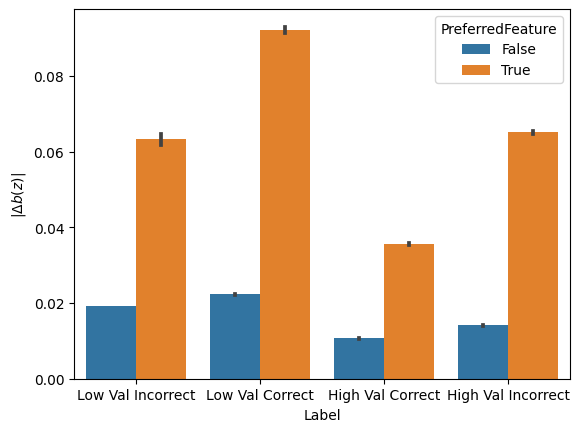

In [17]:
fig, ax = plt.subplots()
sns.barplot(melted, x="Label", hue="PreferredFeature", y="mag", ax=ax)
ax.set_ylabel(r"$|\Delta b(z)|$")

Text(0, 0.5, '$|\\Delta log(b(z))|$')

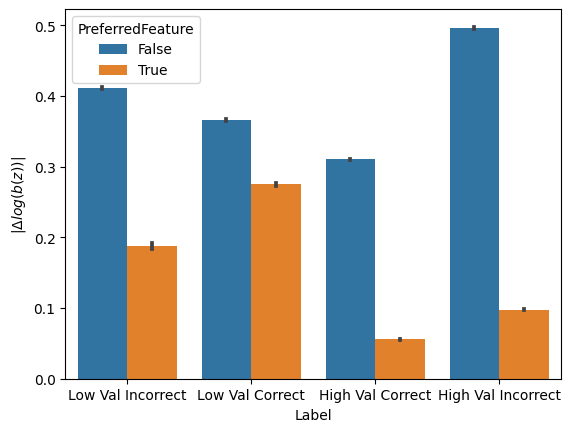

In [18]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin", "PreferredBelief"], value_vars=[f"{feat}LogProbDelta" for feat in FEATURES])
melted["PreferredFeature"] = melted.apply(lambda x: x.PreferredBelief in x.variable, axis=1)
melted["mag"] = melted["value"].abs()
melted["Label"] = melted.apply(lambda x: f"{'Low Val ' if x.BeliefStateValueBin == 0 else 'High Val '}{x.Response}", axis=1)

fig, ax = plt.subplots()
sns.barplot(melted, x="Label", hue="PreferredFeature", y="mag", ax=ax)
ax.set_ylabel(r"$|\Delta log(b(z))|$")

Text(0, 0.5, '$KL$')

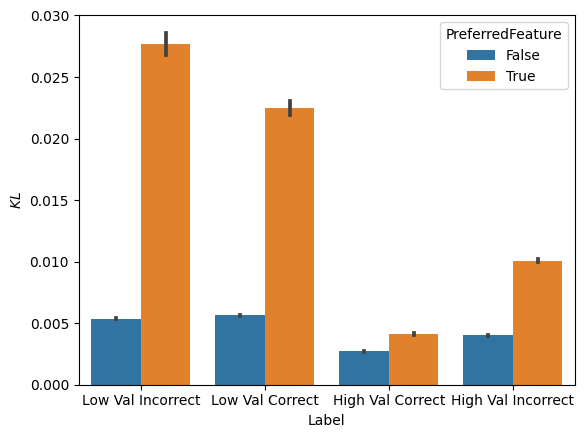

In [10]:
melted = all_beh.melt(id_vars=["CombinedIdx", "Response", "BeliefStateValueBin", "PreferredBelief"], value_vars=[f"{feat}KL" for feat in FEATURES])
melted["PreferredFeature"] = melted.apply(lambda x: x.PreferredBelief in x.variable, axis=1)
melted["Label"] = melted.apply(lambda x: f"{'Low Val ' if x.BeliefStateValueBin == 0 else 'High Val '}{x.Response}", axis=1)

fig, ax = plt.subplots()
sns.barplot(melted, x="Label", hue="PreferredFeature", y="value", ax=ax)
ax.set_ylabel(r"$KL$")

### Some exploration on using KL of the Bernoulli distribution as the metric here

In [17]:
def compute_kl(p_dist, q_dist):
    """
    Assumes two categorical distributions
    p_dist: n_samples x n_categories
    q_dist: n_samples x n_categories
    Returns: 
        kl: n_samples
    """
    return np.sum(p_dist * np.log(p_dist / q_dist), axis=1)

def make_bernoulli_dist(probs):
    dist = np.empty((len(probs), 2))
    dist[:, 0] = probs
    dist[:, 1] = 1 - probs
    return dist

probs = np.arange(0.02, 0.99, 0.01)
dist = make_bernoulli_dist(probs)

inc_dist = make_bernoulli_dist(probs + 0.01)
dec_dist = make_bernoulli_dist(probs - 0.01)

kl_inc = compute_kl(dist, inc_dist)
kl_dec = compute_kl(dist, dec_dist)

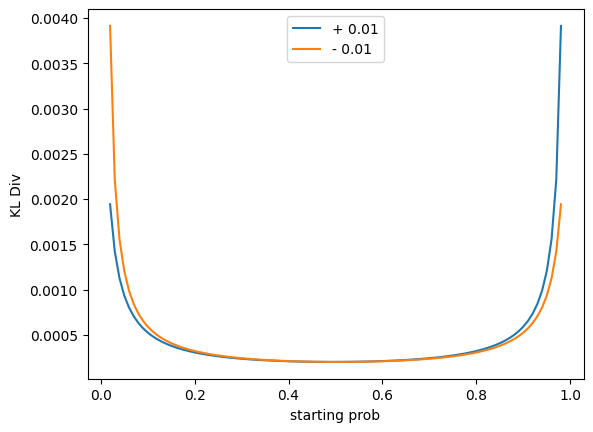

In [19]:
fig, ax = plt.subplots()
ax.plot(probs, kl_inc, label="+ 0.01")
ax.plot(probs, kl_dec, label="- 0.01")
ax.set_xlabel("starting prob")
ax.set_ylabel("KL Div")
ax.legend()